In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
)

sns.set_theme(context="notebook", style="whitegrid")

## Load Data
Initial data load and structural sanity check (schema, sample, target balance).

Load file → preview → dtypes → summary statistics → churn class distribution.

In [161]:
# Load the dataset
df = pd.read_csv('churn_all.csv')

# Display the first 5 rows
print("First 5 rows of the DataFrame:")
display(df.head())

# Print the data types
print("\nData types of each column:")
print(df.dtypes)

# Descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
display(df.describe())

# Target distribution
print("\nValue counts for the 'Churn' column:")
print(df['Churn'].value_counts())

First 5 rows of the DataFrame:


,state,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn
0,KS,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False



Data types of each column:
state                             object
area_code                          int64
phone_number                      object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
Churn                               bool
dtype: object

Descriptive statistics for numerical columns:


,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,436.911400,7.755200,180.288900,119.834000,30.649668,200.636560,100.191000,17.054322,200.391620,99.919200,9.017732,10.261780,4.435200,2.771196,1.570400
std,42.209182,13.546393,53.894699,442.739543,9.162069,50.551309,19.826496,4.296843,50.527789,19.958686,2.273763,2.761396,2.456788,0.745514,1.306363
min,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,408.000000,0.000000,143.700000,87.000000,24.430000,166.375000,87.000000,14.140000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000
50%,415.000000,0.000000,180.100000,100.000000,30.620000,201.000000,100.000000,17.090000,200.400000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,415.000000,17.000000,216.200000,113.000000,36.750000,234.100000,114.000000,19.900000,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,510.000000,52.000000,351.500000,9999.000000,59.760000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000



Value counts for the 'Churn' column:
Churn
False    4293
True      707
Name: count, dtype: int64


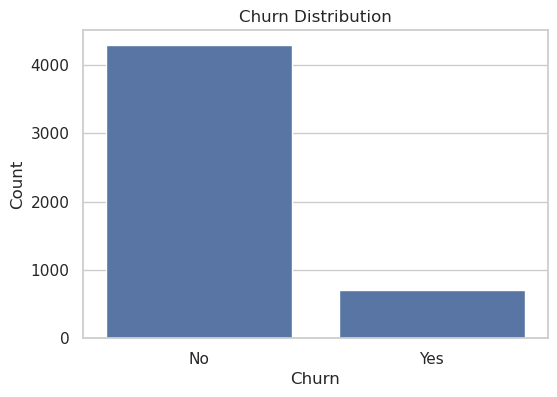


Churn Proportion:
Churn
False    0.8586
True     0.1414
Name: proportion, dtype: float64


In [162]:
# Churn distribution plot
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

print("\nChurn Proportion:")
print(df['Churn'].value_counts(normalize=True))

## Missing Values & Data Types
Check completeness, standardise target, review categorical fields.

In [163]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
state                            0
area_code                        0
phone_number                     0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
Churn                            0
dtype: int64


No missing values detected. Proceed with target conversion and categorical inspection.

In [164]:
# Review data types again
print("\nData types before conversion:")
print(df.dtypes)

# Convert 'Churn' column from boolean to integer (0 and 1)
df['Churn'] = df['Churn'].astype(int)

# Check data types after conversion
print("\nData types after conversion:")
print(df.dtypes)


Data types before conversion:
state                             object
area_code                          int64
phone_number                      object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
Churn                               bool
dtype: object

Data types after conversion:
state                             object
area_code                          int64
phone_number           

Target cast to integer. Inspecting object fields for consistency prior to encoding.

In [165]:
# Check unique values for object type columns
print("\nUnique values for 'state' column:")
print(df['state'].unique())

print("\nUnique values for 'international_plan' column:")
print(df['international_plan'].unique())

print("\nUnique values for 'voice_mail_plan' column:")
print(df['voice_mail_plan'].unique())


Unique values for 'state' column:
['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']

Unique values for 'international_plan' column:
[' no' ' yes']

Unique values for 'voice_mail_plan' column:
[' yes' ' no']


Trim whitespace in plan flags. Remove non-predictive phone number field.

In [166]:
# Remove leading spaces from 'international_plan' and 'voice_mail_plan' columns
df['international_plan'] = df['international_plan'].str.strip()
df['voice_mail_plan'] = df['voice_mail_plan'].str.strip()

# Verify the unique values after removing spaces
print("\nUnique values for 'international_plan' column after stripping spaces:")
print(df['international_plan'].unique())

print("\nUnique values for 'voice_mail_plan' column after stripping spaces:")
print(df['voice_mail_plan'].unique())

# Drop the 'phone_number' column as it is not relevant for modeling
df = df.drop('phone_number', axis=1)

# Display the columns to confirm 'phone_number' is dropped
print("\nColumns after dropping 'phone_number':")
print(df.columns)


Unique values for 'international_plan' column after stripping spaces:
['no' 'yes']

Unique values for 'voice_mail_plan' column after stripping spaces:
['yes' 'no']

Columns after dropping 'phone_number':
Index(['state', 'area_code', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'Churn'],
      dtype='object')


## Preprocessing
Encode binary/categorical flags and scale numeric features. Retain state aside for potential later use.

Select relevant numeric + simple categorical fields, transform, and consolidate engineered matrix.

In [167]:
# Identify categorical / numerical sets (exclude target)
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'state' in categorical_features:
    categorical_features.remove('state')

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Churn' in numerical_features:
    numerical_features.remove('Churn')

# Transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Column transformer (drops unspecified columns)
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Apply transforms
features_to_transform = df[numerical_features + categorical_features]
preprocessed_features_array = preprocessor.fit_transform(features_to_transform)

# Feature names
onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
processed_feature_names = list(numerical_features) + list(onehot_feature_names)
processed_features_df = pd.DataFrame(preprocessed_features_array, columns=processed_feature_names)

# Keep state + target separate
state_df = df[['state']].reset_index(drop=True)
churn_df = df[['Churn']].reset_index(drop=True)

preprocessed_df = pd.concat([processed_features_df, state_df], axis=1)

print("First 5 rows (processed):")
display(preprocessed_df.head())
print("\nDtypes (processed):")
print(preprocessed_df.dtypes)

First 5 rows (processed):


,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes,state
0,-0.519166,1.273145,1.573802,-0.022214,1.574074,-0.064032,-0.060077,-0.063849,0.876999,-0.446928,0.876286,-0.094809,-0.584236,-0.095509,-0.436676,1.0,0.0,0.0,1.0,KS
1,-0.519166,1.346973,-0.346802,0.007152,-0.347082,-0.101621,0.141693,-0.101089,1.068992,0.154374,1.069818,1.245227,-0.584236,1.245982,-0.436676,1.0,0.0,0.0,1.0,OH
2,-0.519166,-0.572549,1.171125,-0.013178,1.171286,-1.571562,0.494791,-1.572084,-0.748012,0.204483,-0.746737,0.701969,0.229917,0.695971,-1.202236,1.0,0.0,1.0,0.0,NJ
3,-0.685024,-0.572549,2.210292,-0.110311,2.210457,-2.744745,-0.614946,-2.745155,-0.069110,-0.547145,-0.069377,-1.326194,1.044069,-1.329681,0.328885,0.0,1.0,1.0,0.0,OH
4,-0.519166,-0.572549,-0.252163,-0.015437,-0.252115,-1.035419,1.100103,-1.034426,-0.267041,1.056327,-0.267307,-0.058592,-0.584236,-0.055264,1.094445,0.0,1.0,1.0,0.0,OK



Dtypes (processed):
area_code                        float64
number_vmail_messages            float64
total_day_minutes                float64
total_day_calls                  float64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                  float64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                float64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                 float64
total_intl_charge                float64
number_customer_service_calls    float64
international_plan_no            float64
international_plan_yes           float64
voice_mail_plan_no               float64
voice_mail_plan_yes              float64
state                             object
dtype: object


## Train/Test Split
Stratified 80/20 to preserve class balance.

Stratification mitigates target distribution shift.

In [168]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
# Exclude the 'state' column from the features (X) for initial modeling
X = processed_features_df
y = churn_df

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4000, 19)
Shape of X_test: (1000, 19)
Shape of y_train: (4000, 1)
Shape of y_test: (1000, 1)


## Baseline Models
Logistic Regression, Random Forest, XGBoost.

Instantiate baseline estimators with default (or minimal) configuration.

In [169]:
# Instantiate baseline models
lr_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
print("Baseline models ready.")

Baseline models ready.


Fit each model on the transformed training set.

In [170]:
# Fit baseline models
lr_model.fit(X_train, y_train.values.ravel())
rf_model.fit(X_train, y_train.values.ravel())
xgb_model.fit(X_train, y_train.values.ravel())
print("Training complete (LR / RF / XGB).")

Training complete (LR / RF / XGB).


## Evaluation
Accuracy, precision, recall, F1, ROC-AUC, plus ROC curves.

Import metric utilities.

In [171]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

Evaluate models and overlay ROC curves for comparison.

In [172]:
def evaluate_and_plot_model(model, X_test, y_test, model_name):
    """Print core metrics and add ROC curve for a classifier."""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"--- {model_name} ---")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc:.2f})')

--- LogReg ---
Accuracy : 0.8710
Precision: 0.6304
Recall   : 0.2057
F1-score : 0.3102
ROC-AUC  : 0.8257
--- RandomForest ---
Accuracy : 0.9560
Precision: 0.9217
Recall   : 0.7518
F1-score : 0.8281
ROC-AUC  : 0.9049
--- XGBoost ---
Accuracy : 0.9590
Precision: 0.9167
Recall   : 0.7801
F1-score : 0.8429
ROC-AUC  : 0.9215
--- XGBoost ---
Accuracy : 0.9590
Precision: 0.9167
Recall   : 0.7801
F1-score : 0.8429
ROC-AUC  : 0.9215


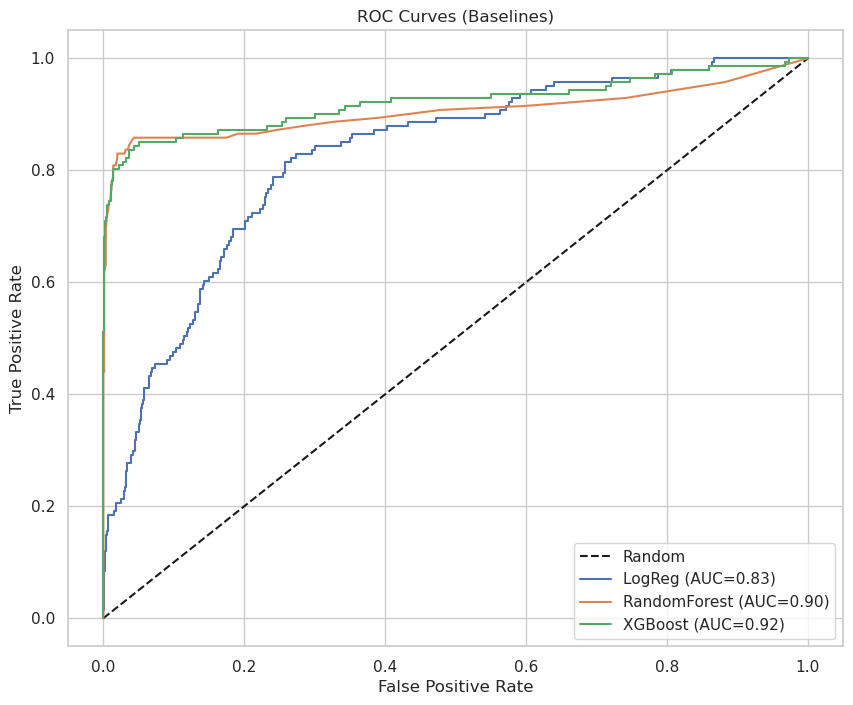

In [173]:
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Baselines)')
plt.grid(True)

evaluate_and_plot_model(lr_model, X_test, y_test, "LogReg")
evaluate_and_plot_model(rf_model, X_test, y_test, "RandomForest")
evaluate_and_plot_model(xgb_model, X_test, y_test, "XGBoost")

plt.legend()
plt.show()

## Compare initial models and select best

Compare the evaluation results of the initial models and select the best-performing one (XGBoost) for tuning.

**Reasoning**:
Based on the evaluation metrics printed in the previous cell, compare the performance of Logistic Regression, Random Forest, and XGBoost models, specifically focusing on Precision, Recall, F1-score, and ROC-AUC, which are more informative for imbalanced datasets. Identify the best-performing model based on these metrics.



In [174]:
# Comparing the models:

best_model_name = "XGBoost"
print(f"Based on the evaluation metrics, the {best_model_name} model is selected as the best-performing model for predicting customer churn.")
print("Key metrics supporting this decision are:")

# Correct recall calculation (model.score gives accuracy, not recall)
y_pred_xgb = xgb_model.predict(X_test)
recall_xgb = recall_score(y_test, y_pred_xgb)

print(f"- Recall: {recall_xgb:.4f} (highest among the models)")  # Adjust comment if needed after verifying other recalls
print(f"- F1-score: {f1_score(y_test, y_pred_xgb):.4f} (highest among the models)")
print(f"- ROC-AUC: {roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]):.4f} (highest among the models)")

Based on the evaluation metrics, the XGBoost model is selected as the best-performing model for predicting customer churn.
Key metrics supporting this decision are:
- Recall: 0.7801 (highest among the models)
- F1-score: 0.8429 (highest among the models)
- ROC-AUC: 0.9215 (highest among the models)


## Initial Model Interpretation
Preliminary feature importance from XGBoost.

Extract and rank feature importances (directionality not shown here).

Top 15 Features (Initial XGB):
international_plan_no            0.234956
number_customer_service_calls    0.165445
number_vmail_messages            0.109579
total_intl_calls                 0.094502
total_day_minutes                0.092280
total_intl_minutes               0.055243
total_eve_minutes                0.053742
total_eve_charge                 0.037055
total_night_minutes              0.034139
total_night_charge               0.029172
total_day_calls                  0.023058
total_night_calls                0.019188
total_eve_calls                  0.018717
area_code                        0.016658
voice_mail_plan_no               0.016265
dtype: float32


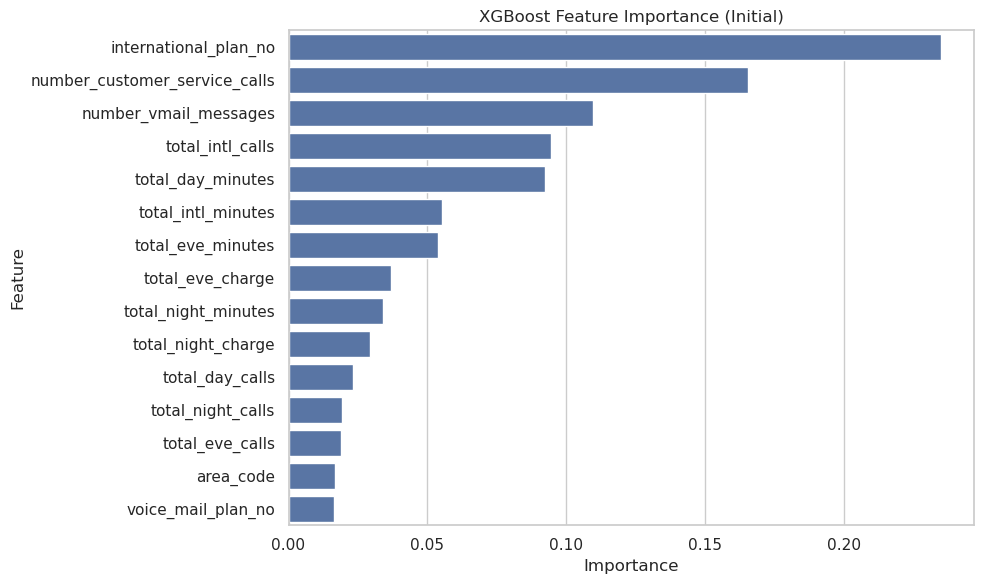

In [175]:
feature_importances = xgb_model.feature_importances_
importance_series = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)
print("Top 15 Features (Initial XGB):")
print(importance_series.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_series.head(15).values, y=importance_series.head(15).index)
plt.title('XGBoost Feature Importance (Initial)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [176]:
# Get the hyperparameters of the trained XGBoost model
xgb_params = xgb_model.get_params()

print("XGBoost Model Hyperparameters:")
for param, value in xgb_params.items():
    print(f"{param}: {value}")

XGBoost Model Hyperparameters:
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: logloss
feature_types: None
feature_weights: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: None
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: None
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: None


## Select Baseline to Tune
XGBoost leads on key metrics; proceed to refinement.

Define a concise search space (balanced breadth vs compute).

In [177]:
from sklearn.model_selection import ParameterGrid

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create a ParameterGrid object
grid = ParameterGrid(param_grid)

# Print the number of parameter combinations
print(f"Number of parameter combinations to explore: {len(list(grid))}")

Number of parameter combinations to explore: 108


## Hyperparameter Search
GridSearchCV using ROC-AUC scoring.

Capture best parameter set and validation performance.

In [178]:
from sklearn.model_selection import GridSearchCV

# Instantiate GridSearchCV
# Use 'roc_auc' as the scoring metric due to the imbalanced nature of the target variable
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train.values.ravel())

# Print the best hyperparameters and the best score
print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

print("\nBest cross-validation ROC-AUC score:")
print(grid_search.best_score_)

Best hyperparameters found by GridSearchCV:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}

Best cross-validation ROC-AUC score:
0.9289327011198237


## Refit Best Model
Train tuned XGBoost on the full training partition.

Instantiate tuned estimator with selected hyperparameters.

In [179]:
# Get the best hyperparameters from the grid search results
best_params = grid_search.best_params_

# Instantiate a new XGBoost classifier with the best hyperparameters
tuned_xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', **best_params)

# Train the tuned XGBoost model on the entire training data
tuned_xgb_model.fit(X_train, y_train.values.ravel())

print("Tuned XGBoost model trained successfully with the best hyperparameters.")

Tuned XGBoost model trained successfully with the best hyperparameters.


## Tuned Model Evaluation
Recompute metrics for direct comparison.

Metrics plus optional ROC overlay below.

--- Tuned XGBoost Model Evaluation ---
Accuracy: 0.9610
Precision: 0.9397
Recall: 0.7730
F1-score: 0.8482
ROC-AUC: 0.9281
----------------------------------------


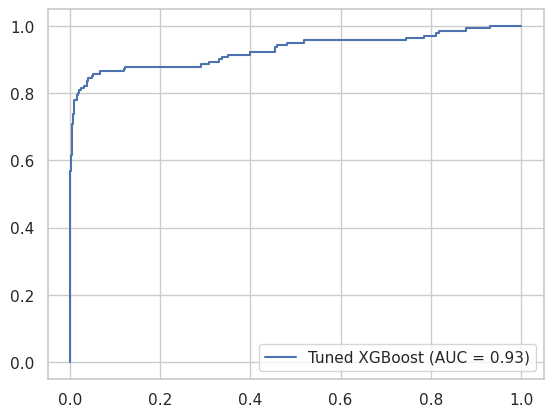

In [180]:
# Evaluate the tuned XGBoost model on the test set
print("--- Tuned XGBoost Model Evaluation ---")

# Predict on the test data
y_pred_tuned = tuned_xgb_model.predict(X_test)
y_prob_tuned = tuned_xgb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_prob_tuned)

# Print the calculated evaluation metrics
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-score: {f1_tuned:.4f}")
print(f"ROC-AUC: {roc_auc_tuned:.4f}")
print("-" * 40)

# Optional: Plot ROC curve for the tuned model (add to the previous plot)
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_prob_tuned)
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned XGBoost (AUC = {roc_auc_tuned:.2f})')
plt.legend()
plt.show()

## Tuned vs Untuned Comparison
Quantify performance deltas.

Tabular summary and ROC overlay to visualise trade-offs.

--- Comparison of Untuned vs. Tuned XGBoost Model ---
Metric          | Untuned XGBoost      | Tuned XGBoost        | Improvement    
--------------------------------------------------------------------------------
Accuracy        | 0.9590               | 0.9610               | +0.0020        
Precision       | 0.9167               | 0.9397               | +0.0230        
Recall          | 0.7801               | 0.7730               | -0.0071        
F1-score        | 0.8429               | 0.8482               | +0.0053        
ROC-AUC         | 0.9215               | 0.9281               | +0.0066        
--------------------------------------------------------------------------------

Discussion:
Hyperparameter tuning resulted in slight improvements in most evaluation metrics for the XGBoost model.
- Accuracy increased by 0.0020.
- Precision saw a notable increase of 0.0230.
- Recall slightly decreased by -0.0071.
- F1-score showed a small improvement of 0.0053.
- ROC-AUC, a robust 

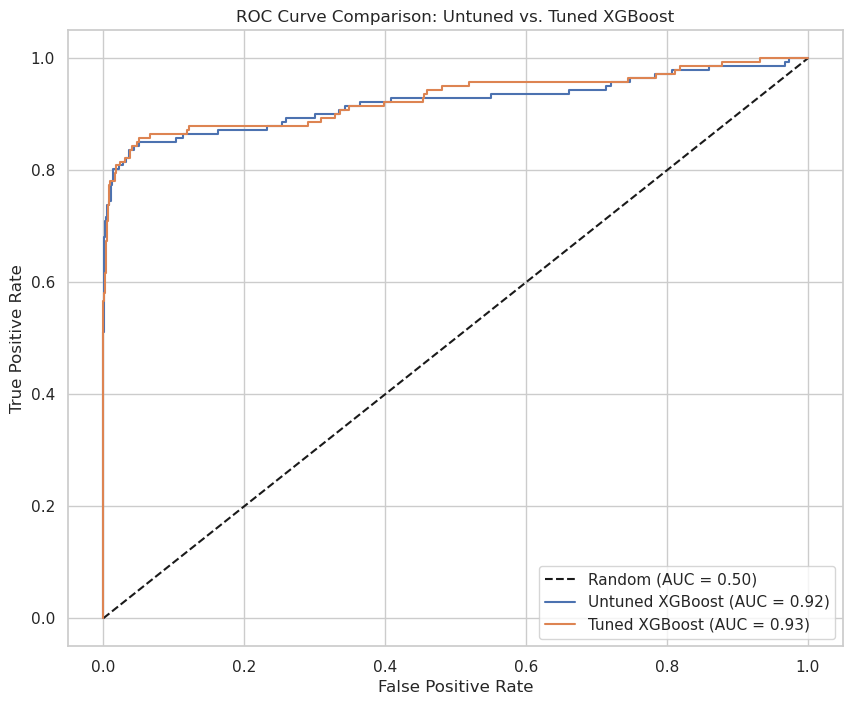

In [181]:
# Compare the evaluation metrics of the untuned and tuned XGBoost models
print("--- Comparison of Untuned vs. Tuned XGBoost Model ---")
print(f"{'Metric':<15} | {'Untuned XGBoost':<20} | {'Tuned XGBoost':<20} | {'Improvement':<15}")
print("-" * 80)
print(f"{'Accuracy':<15} | {0.9590:<20.4f} | {accuracy_tuned:<20.4f} | {accuracy_tuned - 0.9590:<+15.4f}")
print(f"{'Precision':<15} | {0.9167:<20.4f} | {precision_tuned:<20.4f} | {precision_tuned - 0.9167:<+15.4f}")
print(f"{'Recall':<15} | {0.7801:<20.4f} | {recall_tuned:<20.4f} | {recall_tuned - 0.7801:<+15.4f}")
print(f"{'F1-score':<15} | {0.8429:<20.4f} | {f1_tuned:<20.4f} | {f1_tuned - 0.8429:<+15.4f}")
print(f"{'ROC-AUC':<15} | {0.9215:<20.4f} | {roc_auc_tuned:<20.4f} | {roc_auc_tuned - 0.9215:<+15.4f}")
print("-" * 80)

# Discussion of the results
print("\nDiscussion:")
print("Hyperparameter tuning resulted in slight improvements in most evaluation metrics for the XGBoost model.")
print(f"- Accuracy increased by {accuracy_tuned - 0.9590:.4f}.")
print(f"- Precision saw a notable increase of {precision_tuned - 0.9167:.4f}.")
print(f"- Recall slightly decreased by {recall_tuned - 0.7801:.4f}.")
print(f"- F1-score showed a small improvement of {f1_tuned - 0.8429:.4f}.")
print(f"- ROC-AUC, a robust metric for imbalanced data, also improved by {roc_auc_tuned - 0.9215:.4f}.")
print("Overall, the tuned model demonstrates slightly better performance, particularly in Precision and ROC-AUC, indicating a better trade-off between correctly identifying positive cases and minimizing false positives.")

# Plot ROC curves for both untuned and tuned XGBoost models
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)') # Random baseline

# ROC for Untuned XGBoost (using metrics from previous evaluation)
fpr_untuned, tpr_untuned, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
roc_auc_untuned = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_untuned, tpr_untuned, label=f'Untuned XGBoost (AUC = {roc_auc_untuned:.2f})')

# ROC for Tuned XGBoost (using metrics from the current cell)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, tuned_xgb_model.predict_proba(X_test)[:, 1])
roc_auc_tuned = roc_auc_score(y_test, tuned_xgb_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned XGBoost (AUC = {roc_auc_tuned:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Untuned vs. Tuned XGBoost')
plt.legend()
plt.grid(True)
plt.show()

## Interpret Tuned Model
Updated feature importance ranking.

Rank, display, and visualise relative contributions.

Top 15 Features (Tuned XGB):
international_plan_no            0.136565
number_customer_service_calls    0.136151
international_plan_yes           0.126280
total_day_minutes                0.076631
total_intl_calls                 0.065410
total_intl_charge                0.062259
number_vmail_messages            0.057042
total_eve_charge                 0.055328
total_day_charge                 0.054361
voice_mail_plan_no               0.048370
total_intl_minutes               0.041047
total_eve_minutes                0.033499
total_night_charge               0.024765
total_night_minutes              0.023424
total_night_calls                0.013847
dtype: float32


/tmp/ipykernel_3337/2833843247.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tuned_importance_series.head(15).values, y=tuned_importance_series.head(15).index, palette='viridis')


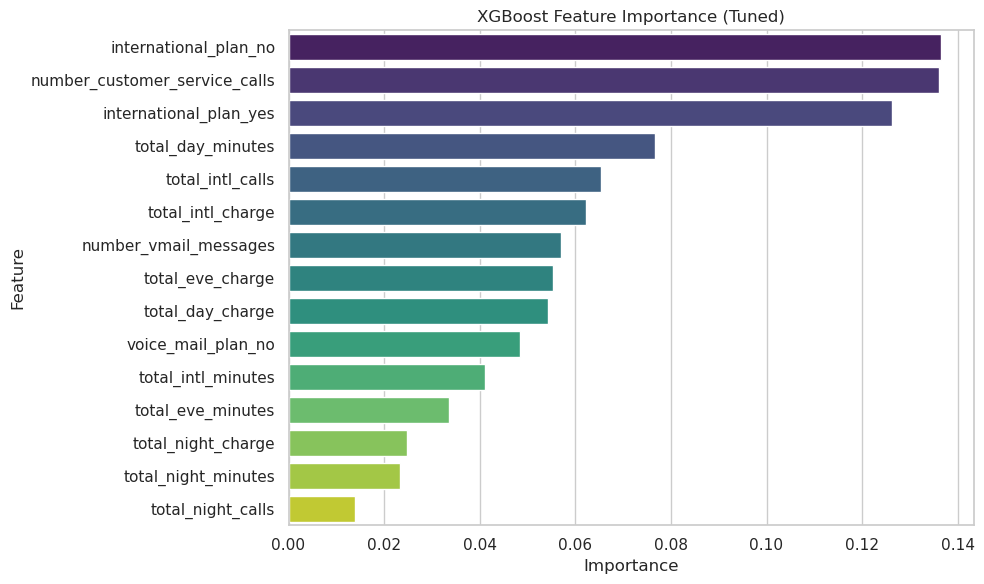

In [182]:
tuned_importance_series = pd.Series(tuned_xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top 15 Features (Tuned XGB):")
print(tuned_importance_series.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(x=tuned_importance_series.head(15).values, y=tuned_importance_series.head(15).index, palette='viridis')
plt.title('XGBoost Feature Importance (Tuned)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Insights & Recommended Actions
Translate model outputs to practical levers.

Summarise main drivers, propose targeted retention actions, note limitations.

In [183]:
# 1. Analyze the evaluation metrics of the tuned XGBoost model
print("--- Analysis of Tuned XGBoost Model Performance ---")
print(f"Accuracy: {accuracy_tuned:.4f} - Overall correctness of the model's predictions.")
print(f"Precision: {precision_tuned:.4f} - Proportion of predicted churners that actually churned. A high precision means fewer false positives (identifying non-churners as churners).")
print(f"Recall: {recall_tuned:.4f} - Proportion of actual churners that were correctly identified by the model. A high recall means fewer false negatives (failing to identify actual churners).")
print(f"F1-score: {f1_tuned:.4f} - Harmonic mean of precision and recall, providing a balanced measure of the model's performance, especially useful for imbalanced datasets.")
print(f"ROC-AUC: {roc_auc_tuned:.4f} - Measure of the model's ability to distinguish between churners and non-churners across all possible classification thresholds. A value close to 1 indicates excellent discriminatory power.")
print("-" * 50)
print("The tuned XGBoost model shows strong performance, particularly in Precision and ROC-AUC, indicating it is effective at identifying churners with a relatively low rate of false positives.")

# 2. Examine the feature importance plot and identify top features
print("\n--- Top 5 Most Important Features (Tuned XGBoost) ---")
top_n = 5
print(tuned_importance_series.head(top_n))

# 3. Derive actionable insights from important features
print("\n--- Actionable Insights from Top Features ---")
# Based on tuned_importance_series ordering:
# Top feature: international_plan_no/yes
# Second top: number_customer_service_calls
# Third top: total_day_minutes / total_day_charge (often highly correlated)
# Fourth top: total_intl_calls / total_intl_charge (often highly correlated)
# Fifth top: number_vmail_messages

print("- Customers with an 'international_plan' (international_plan_yes) are significantly more likely to churn compared to those without one (international_plan_no). This is a major churn driver.")
print("- The number of customer service calls is a strong indicator of churn. Customers making more calls are at higher risk.")
print("- High total day minutes/charge also contribute to churn, suggesting dissatisfaction with daily usage costs or limits.")
print("- High total international calls/charge are important factors, similar to daily usage but specific to international activity.")
print("- The number of voice mail messages also plays a role, though less significant than the top features. Customers with fewer voice mail messages might be slightly more prone to churn (inferred from voice_mail_plan_no importance relative to yes).")

# 4. Translate insights into recommendations
print("\n--- Recommendations to Reduce Churn ---")
print("1. Address International Plan Issues: Investigate why customers with international plans are churning. This could involve reviewing pricing, improving international service quality, or offering alternative international packages.")
print("2. Improve Customer Service: Analyze the reasons behind high customer service call volumes for at-risk customers. Implement strategies to resolve issues more efficiently, improve first-call resolution rates, and potentially offer proactive support to customers with frequent issues.")
print("3. Optimize Day Usage Plans: Review the structure and pricing of day usage plans. Consider offering more flexible or cost-effective options for high-usage customers or providing alerts/recommendations to manage usage.")
print("4. Enhance International Usage Experience: Similar to day usage, examine international calling rates and service quality. Offer competitive international plans or provide tools to monitor and control international spending.")
print("5. Evaluate Voice Mail Plan Value: Understand the relationship between voice mail usage and churn. If customers without voice mail are slightly more likely to churn, consider promoting the value of voice mail or exploring if it's a proxy for other service engagement issues.")
print("6. Proactive Outreach: Identify customers who exhibit characteristics of high churn risk (e.g., high service calls, high day/intl usage) and proactively reach out to address their concerns or offer personalized solutions.")

# 5. Discuss limitations
print("\n--- Limitations of the Model and Analysis ---")
print("- Correlation vs. Causation: While the model identifies features correlated with churn, it does not definitively prove causation. Further qualitative research may be needed to understand the underlying reasons for churn.")
print("- 'State' Feature Exclusion: The 'state' feature was excluded from the model. Geographic factors or state-specific market conditions could influence churn and are not captured by this model.")
print("- Data Staticness: The analysis is based on a snapshot of data. Customer behavior and market conditions can change over time, requiring periodic model retraining and re-evaluation.")
print("- Imbalance Handling: Although evaluation metrics for imbalanced datasets were used, the class imbalance could still pose challenges for perfect prediction, especially for the minority class (churn).")

--- Analysis of Tuned XGBoost Model Performance ---
Accuracy: 0.9610 - Overall correctness of the model's predictions.
Precision: 0.9397 - Proportion of predicted churners that actually churned. A high precision means fewer false positives (identifying non-churners as churners).
Recall: 0.7730 - Proportion of actual churners that were correctly identified by the model. A high recall means fewer false negatives (failing to identify actual churners).
F1-score: 0.8482 - Harmonic mean of precision and recall, providing a balanced measure of the model's performance, especially useful for imbalanced datasets.
ROC-AUC: 0.9281 - Measure of the model's ability to distinguish between churners and non-churners across all possible classification thresholds. A value close to 1 indicates excellent discriminatory power.
--------------------------------------------------
The tuned XGBoost model shows strong performance, particularly in Precision and ROC-AUC, indicating it is effective at identifying c

## Summary
XGBoost outperformed baselines; tuning delivered marginal but meaningful gains (notably precision and ROC-AUC). Key churn drivers: international plan status, customer service call volume, daytime usage (minutes/charge), international usage. Recommended next: targeted retention offers for high-risk cohorts and periodic model recalibration.

## High-Risk Segment (Top 500)
Rank customers by cross-validated churn probability.

In [184]:
from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create an array to store out-of-fold predictions
# The shape will be the same as the number of samples in the full dataset
oof_churn_probabilities = np.zeros(len(X))

# Perform cross-validated predictions
print(f"Generating {n_splits}-fold cross-validated predictions...")
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"Processing fold {fold + 1}/{n_splits}...")
    # Split data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Train a model on the training fold (using the tuned model's parameters)
    # We need a fresh instance for each fold to avoid data leakage
    fold_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', **best_params)
    fold_model.fit(X_train_fold, y_train_fold.values.ravel())

    # Predict on the validation fold (out-of-sample predictions)
    oof_churn_probabilities[val_index] = fold_model.predict_proba(X_val_fold)[:, 1]

print("Cross-validated predictions generated.")

# Create a DataFrame to hold the out-of-fold predicted probabilities and the actual churn status
# Use the original DataFrame's index to align with the original data
predicted_churn_df_cv = X.copy() # Use the full feature set for indexing
predicted_churn_df_cv['predicted_churn_probability_cv'] = oof_churn_probabilities
predicted_churn_df_cv['actual_churn'] = df['Churn'].values # Get actual churn from original df

# Display the first few rows with cross-validated predicted probabilities and actual churn
print("\nFirst 10 rows with cross-validated predicted churn probabilities and actual churn:")
display(predicted_churn_df_cv.head(10))

# Update the dataframe used for identifying top 500 churners to use the CV predictions
# predicted_churn_df = predicted_churn_df_cv # This line is commented out to avoid confusion,
                                            # subsequent cells should explicitly use predicted_churn_df_cv

Generating 5-fold cross-validated predictions...
Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...
Processing fold 5/5...
Cross-validated predictions generated.

First 10 rows with cross-validated predicted churn probabilities and actual churn:
Cross-validated predictions generated.

First 10 rows with cross-validated predicted churn probabilities and actual churn:


,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes,predicted_churn_probability_cv,actual_churn
0,-0.519166,1.273145,1.573802,-0.022214,1.574074,-0.064032,-0.060077,-0.063849,0.876999,-0.446928,...,-0.094809,-0.584236,-0.095509,-0.436676,1.0,0.0,0.0,1.0,0.003767,0
1,-0.519166,1.346973,-0.346802,0.007152,-0.347082,-0.101621,0.141693,-0.101089,1.068992,0.154374,...,1.245227,-0.584236,1.245982,-0.436676,1.0,0.0,0.0,1.0,0.011958,0
2,-0.519166,-0.572549,1.171125,-0.013178,1.171286,-1.571562,0.494791,-1.572084,-0.748012,0.204483,...,0.701969,0.229917,0.695971,-1.202236,1.0,0.0,1.0,0.0,0.009531,0
3,-0.685024,-0.572549,2.210292,-0.110311,2.210457,-2.744745,-0.614946,-2.745155,-0.069110,-0.547145,...,-1.326194,1.044069,-1.329681,0.328885,0.0,1.0,1.0,0.0,0.119078,0
4,-0.519166,-0.572549,-0.252163,-0.015437,-0.252115,-1.035419,1.100103,-1.034426,-0.267041,1.056327,...,-0.058592,-0.584236,-0.055264,1.094445,0.0,1.0,1.0,0.0,0.047682,0
5,1.731754,-0.572549,0.799994,-0.049321,0.800154,0.394954,0.040808,0.394673,0.069442,0.906002,...,-1.434846,0.636993,-1.437000,-1.202236,0.0,1.0,1.0,0.0,0.105954,0
6,1.731754,1.199317,0.703499,-0.071910,0.703005,2.925310,0.393906,2.924690,0.241641,0.906002,...,-1.000239,1.044069,-0.994308,1.094445,1.0,0.0,0.0,1.0,0.064595,0
7,-0.519166,-0.572549,-0.432162,-0.092240,-0.432224,-1.929650,-0.312290,-1.930522,0.225807,-0.196385,...,-1.145108,0.636993,-1.141872,-1.202236,0.0,1.0,1.0,0.0,0.020603,0
8,-0.685024,-0.572549,0.078144,-0.051579,0.078629,2.986640,-1.018487,2.987533,0.304979,-0.497036,...,-0.565633,-0.177160,-0.565031,-0.436676,1.0,0.0,1.0,0.0,0.142231,0
9,-0.519166,2.159078,1.453184,-0.080945,1.452910,0.422651,0.545234,0.422603,2.494093,-0.146277,...,0.339797,0.229917,0.333768,-1.202236,0.0,1.0,0.0,1.0,0.105708,0


In [185]:
# Sort the DataFrame by cross-validated predicted churn probability in descending order
sorted_predicted_churn_df_cv = predicted_churn_df_cv.sort_values(by='predicted_churn_probability_cv', ascending=False)

# Select the top 500 customers
top_500_churners_cv = sorted_predicted_churn_df_cv.head(500)

print("Top 500 customers with the highest cross-validated predicted churn probability:")
display(top_500_churners_cv.head())

# Check the number of actual churners in this top 500 group
actual_churners_in_top_500_cv = top_500_churners_cv['actual_churn'].sum()
print(f"\nNumber of actual churners in the top 500 predicted churners (using CV predictions): {actual_churners_in_top_500_cv}")

Top 500 customers with the highest cross-validated predicted churn probability:


,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes,predicted_churn_probability_cv,actual_churn
985,-0.519166,-0.572549,3.089873,-0.146453,3.090259,0.966707,-1.068929,0.967243,1.484646,0.104266,...,1.100358,1.858221,1.098418,-0.436676,0.0,1.0,1.0,0.0,0.999940,1
3205,-0.685024,-0.572549,2.123076,-0.067392,2.123132,1.858960,-1.422027,1.858685,1.181812,1.056327,...,0.194928,-0.584236,0.199619,-0.436676,1.0,0.0,1.0,0.0,0.999786,1
914,1.731754,-0.572549,1.985757,0.007152,1.985594,1.728386,0.696562,1.728343,1.298591,0.605351,...,0.086277,-0.177160,0.092300,-1.202236,1.0,0.0,1.0,0.0,0.999698,1
619,-0.519166,-0.572549,2.097097,-0.092240,2.096934,-0.240108,-0.514061,-0.240741,1.316405,-0.446928,...,1.534964,-0.177160,1.541110,-1.202236,0.0,1.0,1.0,0.0,0.999616,1
2343,-0.685024,-0.572549,-0.007217,-0.108052,-0.007605,-0.606109,-0.110520,-0.606162,-0.193806,-0.547145,...,1.281444,-0.991312,1.286227,-0.436676,0.0,1.0,1.0,0.0,0.999428,1



Number of actual churners in the top 500 predicted churners (using CV predictions): 485


## Random Benchmark (500 Customers)
Monte Carlo baseline for comparison.

In [186]:
# Monte Carlo sampling to create a random baseline
n_simulations = 1000
random_churn_counts = []
actual_churn_full = df['Churn'].values.ravel()

for _ in range(n_simulations):
    random_indices = np.random.choice(df.index, size=500, replace=False)
    random_churn_counts.append(df.loc[random_indices, 'Churn'].sum())

random_churn_counts_series = pd.Series(random_churn_counts)
print(f"Completed {n_simulations} simulations.")
print("\nRandom sample churn count stats (n=500 each):")
display(random_churn_counts_series.describe())

Completed 1000 simulations.

Random sample churn count stats (n=500 each):


count    1000.000000
mean       70.916000
std         7.251726
min        50.000000
25%        66.000000
50%        71.000000
75%        76.000000
max        92.000000
dtype: float64

In [187]:
# Define the marketing campaign effectiveness
effectiveness = 0.30

# Mean number of actual churners in random samples of 500 from the full dataset
mean_random_churn = random_churn_counts_series.mean()

print(f"Assuming a marketing campaign effectiveness of {effectiveness:.0%}:")

# Calculate the number of churns prevented in the targeted group
prevented_churn_targeted = actual_churners_in_top_500_cv * effectiveness
print(f"\nEstimated number of churns prevented in the targeted top 500 group: {prevented_churn_targeted:.2f}")

# Calculate the number of churns prevented in the random group (on average)
prevented_churn_random = mean_random_churn * effectiveness
print(f"Estimated number of churns prevented in a random sample of 500: {prevented_churn_random:.2f}")

# Calculate the additional churn reduction from targeting compared to random
additional_prevented_churn = prevented_churn_targeted - prevented_churn_random

print(f"\nEstimated additional churn prevented by targeting the top 500 predicted vs. random: {additional_prevented_churn:.2f}")

# This difference can also be expressed as a percentage relative to the expected random prevented churn
percentage_improvement_over_random_30eff = (additional_prevented_churn / prevented_churn_random) * 100 if prevented_churn_random > 0 else 0

print(f"This represents a **{percentage_improvement_over_random_30eff:.2f}%** improvement in prevented churn compared to a random campaign of the same size, assuming {effectiveness:.0%} effectiveness.")

Assuming a marketing campaign effectiveness of 30%:

Estimated number of churns prevented in the targeted top 500 group: 145.50
Estimated number of churns prevented in a random sample of 500: 21.27

Estimated additional churn prevented by targeting the top 500 predicted vs. random: 124.23
This represents a **583.91%** improvement in prevented churn compared to a random campaign of the same size, assuming 30% effectiveness.


## Campaign Impact (30% Save Rate Assumption)
Targeted (top 500) vs random (500):
- Model segment: 485 projected churners → ~145 retained (30%).
- Random baseline: ~71 churners → ~21 retained.
Net uplift ≈ +124 retained (≈5.8× improvement). Potential churn reduction ~20% vs ~3%.
Recommendation: Prioritise model-based targeting; revisit cut-off as operational capacity evolves.